# Deep Q-learning or Q-network (DQN)

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.12.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0') # 200 total reward as goal
env = gym.make('CartPole-v1') # 500 total reward as goal

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
# env.reset()
# batch = []
# for _ in range(1000):
#     # env.render()
#     action = env.action_space.sample()
#     state, reward, done, info = env.step(action) # take a random action
#     batch.append([action, state, reward, done, info])
#     #print('state, action, reward, done, info:', state, action, reward, done, info)
#     if done:
#         env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# batch[0], batch[0][1].shape

In [6]:
# actions = np.array([each[0] for each in batch])
# states = np.array([each[1] for each in batch])
# rewards = np.array([each[2] for each in batch])
# dones = np.array([each[3] for each in batch])
# infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    is_training = tf.placeholder(tf.bool, name='is_training')
    return actions, states, targetQs, is_training

In [9]:
def init_xavier(random_seed=1, dtype=tf.float32, uniform=False):
    xavier = tf.contrib.layers.xavier_initializer(
        dtype=dtype,
        seed=tf.set_random_seed(random_seed), 
        uniform=uniform) # False: normal
    return xavier

In [10]:
def mlp(inputs, units, trainable=True):
    outputs = tf.layers.dense(
        inputs=inputs,
        units=units,
        activation=None,
        use_bias=True,
        kernel_initializer=init_xavier(), # Xavier with normal init
        bias_initializer=tf.zeros_initializer(),
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        trainable=trainable,
        name=None,
        reuse=None)
    return outputs

In [11]:
# tf.nn.leaky_relu(
#     features,
#     alpha=0.2,
#     name=None
# )
def nl(inputs, alpha=0.2):
    outputs = tf.maximum(alpha * inputs, inputs)
    return outputs

In [12]:
def bn(inputs, training=True):
    outputs = tf.layers.batch_normalization(
        inputs=inputs,
        axis=-1,
        momentum=0.99,
        epsilon=0.001,
        center=True,
        scale=True,
        beta_initializer=tf.zeros_initializer(),
        gamma_initializer=tf.ones_initializer(),
        moving_mean_initializer=tf.zeros_initializer(),
        moving_variance_initializer=tf.ones_initializer(),
        beta_regularizer=None,
        gamma_regularizer=None,
        beta_constraint=None,
        gamma_constraint=None,
        training=training,
        trainable=True,
        name=None,
        reuse=None,
        renorm=False,
        renorm_clipping=None,
        renorm_momentum=0.99,
        fused=None,
        virtual_batch_size=None,
        adjustment=None)
    return outputs

In [13]:
# Actor-Critic/ D/Q
def D(states, action_size, hidden_size, reuse=False, alpha=0.2, is_training=False):
    with tf.variable_scope('D', reuse=reuse):
        # First fully connected layer
        h = mlp(inputs=states, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(states.shape, h.shape)
        
        # Second fully connected layer
        h = mlp(inputs=h, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(h.shape)
        
        # Output layer
        actions = mlp(inputs=h, units=action_size)
        return actions

In [14]:
def model_loss(actions, states, targetQs, action_size, hidden_size, is_training):
    
    actions_logits = D(states=states, hidden_size=hidden_size, action_size=action_size, 
                       is_training=is_training)
    
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    
    loss = tf.reduce_mean((Qs - targetQs)**2)
    
    return actions_logits, loss

In [15]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('D')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=d_vars)

    return opt

In [16]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs, self.is_training = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size,
            states=self.states, actions=self.actions, targetQs=self.targetQs, 
            is_training=self.is_training)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [17]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [18]:
# print('state size:{}'.format(states.shape), 
#       'actions:{}'.format(actions.shape)) 
# print('action size:', np.max(actions) - np.min(actions)+1)

In [19]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
gamma = 0.99                   # future reward discount

In [20]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

(?, 4) (?, 64)
(?, 64)


## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [21]:
state = env.reset()

for _ in range(memory_size):
    
    action = env.action_space.sample()
    
    next_state, reward, done, _ = env.step(action)
    
    memory.buffer.append([state, action, next_state, reward, float(done)])
    
    state = next_state
    
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
def learn(sess, memory, batch_size):
    batch = memory.sample(batch_size)
    states = np.array([each[0] for each in batch])
    actions = np.array([each[1] for each in batch])
    next_states = np.array([each[2] for each in batch])
    rewards = np.array([each[3] for each in batch])
    dones = np.array([each[4] for each in batch])
    
    next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states, 
                                                                      model.is_training: False})
    
    nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
    
    targetQs = rewards + (gamma * nextQs)
    
    loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                             model.actions: actions,
                                                             model.targetQs: targetQs, 
                                                             model.is_training: True})
    return loss

In [23]:
def act(sess, state):
    
    action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1]), 
                                                              model.is_training: False})
    
    action = np.argmax(action_logits, axis=1)[0]
    #print(action)
    
    return action

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action = act(sess, state)
            next_state, reward, done, _ = env.step(action)
            
            memory.buffer.append([state, action, next_state, reward, float(done)])
            
            total_reward += reward
            state = next_state

            # Training
            loss = learn(sess, memory, batch_size)
            loss_batch.append(loss)
            
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:13.0000 R:13.0 loss:0.7316 exploreP:0.9987
Episode:1 meanR:19.5000 R:26.0 loss:0.7303 exploreP:0.9961
Episode:2 meanR:25.6667 R:38.0 loss:0.6658 exploreP:0.9924
Episode:3 meanR:26.7500 R:30.0 loss:0.6524 exploreP:0.9895
Episode:4 meanR:24.6000 R:16.0 loss:0.6661 exploreP:0.9879
Episode:5 meanR:26.5000 R:36.0 loss:0.6619 exploreP:0.9844
Episode:6 meanR:24.8571 R:15.0 loss:0.6307 exploreP:0.9829
Episode:7 meanR:25.1250 R:27.0 loss:0.7232 exploreP:0.9803
Episode:8 meanR:24.4444 R:19.0 loss:0.6777 exploreP:0.9785
Episode:9 meanR:23.5000 R:15.0 loss:0.7151 exploreP:0.9770
Episode:10 meanR:23.1818 R:20.0 loss:0.8311 exploreP:0.9751
Episode:11 meanR:23.0000 R:21.0 loss:0.7825 exploreP:0.9730
Episode:12 meanR:22.9231 R:22.0 loss:0.9048 exploreP:0.9709
Episode:13 meanR:22.3571 R:15.0 loss:0.8987 exploreP:0.9695
Episode:14 meanR:24.1333 R:49.0 loss:1.0497 exploreP:0.9648
Episode:15 meanR:23.5625 R:15.0 loss:1.5216 exploreP:0.9634
Episode:16 meanR:23.1176 R:16.0 loss:1.6131 explor

Episode:135 meanR:23.8600 R:34.0 loss:26.9404 exploreP:0.7250
Episode:136 meanR:23.9500 R:21.0 loss:20.3799 exploreP:0.7235
Episode:137 meanR:24.1500 R:32.0 loss:17.7006 exploreP:0.7212
Episode:138 meanR:24.5700 R:55.0 loss:14.7786 exploreP:0.7173
Episode:139 meanR:25.0300 R:63.0 loss:10.1156 exploreP:0.7129
Episode:140 meanR:25.1900 R:26.0 loss:7.6407 exploreP:0.7111
Episode:141 meanR:25.1700 R:25.0 loss:9.1568 exploreP:0.7093
Episode:142 meanR:25.5400 R:46.0 loss:7.4909 exploreP:0.7061
Episode:143 meanR:25.8000 R:38.0 loss:7.5028 exploreP:0.7035
Episode:144 meanR:25.6000 R:12.0 loss:6.1893 exploreP:0.7026
Episode:145 meanR:25.6300 R:20.0 loss:6.9465 exploreP:0.7013
Episode:146 meanR:26.1300 R:73.0 loss:8.7872 exploreP:0.6962
Episode:147 meanR:26.2200 R:21.0 loss:24.1319 exploreP:0.6948
Episode:148 meanR:26.1900 R:21.0 loss:22.0682 exploreP:0.6933
Episode:149 meanR:26.7500 R:75.0 loss:21.4058 exploreP:0.6882
Episode:150 meanR:26.8100 R:36.0 loss:17.6730 exploreP:0.6858
Episode:151 mea

Episode:268 meanR:59.4800 R:228.0 loss:33.2643 exploreP:0.3598
Episode:269 meanR:60.8500 R:165.0 loss:38.7922 exploreP:0.3541
Episode:270 meanR:61.9200 R:155.0 loss:40.7942 exploreP:0.3488
Episode:271 meanR:63.1100 R:151.0 loss:43.6326 exploreP:0.3437
Episode:272 meanR:64.8400 R:193.0 loss:45.2881 exploreP:0.3373
Episode:273 meanR:65.9400 R:150.0 loss:40.1706 exploreP:0.3325
Episode:274 meanR:67.3100 R:191.0 loss:46.0008 exploreP:0.3264
Episode:275 meanR:68.3800 R:130.0 loss:47.7376 exploreP:0.3223
Episode:276 meanR:70.5400 R:300.0 loss:49.1453 exploreP:0.3131
Episode:277 meanR:72.8300 R:258.0 loss:55.5783 exploreP:0.3053
Episode:278 meanR:73.4700 R:125.0 loss:59.4734 exploreP:0.3017
Episode:279 meanR:73.9400 R:108.0 loss:59.6565 exploreP:0.2985
Episode:280 meanR:76.6400 R:283.0 loss:56.1810 exploreP:0.2905
Episode:281 meanR:78.4700 R:210.0 loss:55.4755 exploreP:0.2847
Episode:282 meanR:80.6400 R:257.0 loss:59.1473 exploreP:0.2777
Episode:283 meanR:82.2800 R:187.0 loss:62.9589 exploreP

Episode:396 meanR:189.2200 R:10.0 loss:287.3043 exploreP:0.0384
Episode:397 meanR:187.2900 R:11.0 loss:343.6892 exploreP:0.0384
Episode:398 meanR:185.1000 R:10.0 loss:782.5922 exploreP:0.0384
Episode:399 meanR:182.6100 R:13.0 loss:448.9985 exploreP:0.0383
Episode:400 meanR:180.5100 R:17.0 loss:301.5961 exploreP:0.0383
Episode:401 meanR:179.3000 R:83.0 loss:242.5526 exploreP:0.0381
Episode:402 meanR:178.2500 R:117.0 loss:391.7923 exploreP:0.0377
Episode:403 meanR:176.2700 R:10.0 loss:900.0452 exploreP:0.0377
Episode:404 meanR:173.5600 R:10.0 loss:354.6699 exploreP:0.0377
Episode:405 meanR:170.8000 R:13.0 loss:340.9233 exploreP:0.0376
Episode:406 meanR:168.1300 R:19.0 loss:550.8918 exploreP:0.0376
Episode:407 meanR:166.6500 R:18.0 loss:272.3228 exploreP:0.0375
Episode:408 meanR:162.8700 R:10.0 loss:348.6152 exploreP:0.0375
Episode:409 meanR:160.0800 R:9.0 loss:565.2644 exploreP:0.0375
Episode:410 meanR:156.0100 R:9.0 loss:180.5305 exploreP:0.0375
Episode:411 meanR:152.9200 R:12.0 loss:24

Episode:526 meanR:100.8000 R:22.0 loss:5813.0620 exploreP:0.0198
Episode:527 meanR:100.9600 R:27.0 loss:2779.1011 exploreP:0.0198
Episode:528 meanR:101.3200 R:46.0 loss:2401.9971 exploreP:0.0197
Episode:529 meanR:100.6100 R:43.0 loss:2292.7275 exploreP:0.0197
Episode:530 meanR:100.7200 R:20.0 loss:2703.8145 exploreP:0.0196
Episode:531 meanR:104.3000 R:371.0 loss:2736.7996 exploreP:0.0193
Episode:532 meanR:104.1400 R:13.0 loss:1407.4884 exploreP:0.0193
Episode:533 meanR:104.2000 R:16.0 loss:2172.2971 exploreP:0.0193
Episode:534 meanR:104.2700 R:16.0 loss:3021.2444 exploreP:0.0193
Episode:535 meanR:104.1300 R:10.0 loss:1056.3794 exploreP:0.0192
Episode:536 meanR:103.5200 R:9.0 loss:1302.6982 exploreP:0.0192
Episode:537 meanR:103.5200 R:10.0 loss:361.2984 exploreP:0.0192
Episode:538 meanR:103.3800 R:10.0 loss:3241.3257 exploreP:0.0192
Episode:539 meanR:103.2600 R:10.0 loss:1974.4030 exploreP:0.0192
Episode:540 meanR:103.3600 R:28.0 loss:1742.9647 exploreP:0.0192
Episode:541 meanR:101.4700

Episode:655 meanR:21.3200 R:11.0 loss:2938.3223 exploreP:0.0172
Episode:656 meanR:21.3100 R:11.0 loss:3610.4414 exploreP:0.0172
Episode:657 meanR:21.3000 R:10.0 loss:1052.2185 exploreP:0.0172
Episode:658 meanR:21.3400 R:18.0 loss:2081.1494 exploreP:0.0172
Episode:659 meanR:21.3700 R:18.0 loss:1654.2059 exploreP:0.0172
Episode:660 meanR:21.4000 R:14.0 loss:2961.7583 exploreP:0.0172
Episode:661 meanR:21.4200 R:17.0 loss:1894.7645 exploreP:0.0171
Episode:662 meanR:21.5600 R:26.0 loss:896.1749 exploreP:0.0171
Episode:663 meanR:21.6800 R:25.0 loss:2172.0664 exploreP:0.0171
Episode:664 meanR:21.7800 R:23.0 loss:1677.8098 exploreP:0.0171
Episode:665 meanR:21.7300 R:20.0 loss:2921.0962 exploreP:0.0171
Episode:666 meanR:21.6400 R:28.0 loss:1937.8044 exploreP:0.0171
Episode:667 meanR:21.7700 R:39.0 loss:1585.2126 exploreP:0.0170
Episode:668 meanR:21.9300 R:38.0 loss:1528.6593 exploreP:0.0170
Episode:669 meanR:21.9900 R:26.0 loss:676.0894 exploreP:0.0170
Episode:670 meanR:22.0800 R:26.0 loss:1807

Episode:785 meanR:22.8600 R:13.0 loss:1652.4178 exploreP:0.0153
Episode:786 meanR:22.8900 R:21.0 loss:1639.8479 exploreP:0.0153
Episode:787 meanR:22.5200 R:20.0 loss:1549.7046 exploreP:0.0153
Episode:788 meanR:22.1700 R:21.0 loss:7106.1333 exploreP:0.0153
Episode:789 meanR:21.6200 R:23.0 loss:1477.8833 exploreP:0.0153
Episode:790 meanR:21.5800 R:26.0 loss:3315.0940 exploreP:0.0153
Episode:791 meanR:21.6300 R:28.0 loss:3091.3274 exploreP:0.0153
Episode:792 meanR:21.6900 R:24.0 loss:4455.4341 exploreP:0.0153
Episode:793 meanR:21.5600 R:18.0 loss:2986.6182 exploreP:0.0152
Episode:794 meanR:21.5300 R:17.0 loss:2672.8369 exploreP:0.0152
Episode:795 meanR:21.5800 R:20.0 loss:2682.4592 exploreP:0.0152
Episode:796 meanR:21.5500 R:24.0 loss:3584.4163 exploreP:0.0152
Episode:797 meanR:21.4300 R:25.0 loss:2541.3396 exploreP:0.0152
Episode:798 meanR:21.5000 R:26.0 loss:4768.2383 exploreP:0.0152
Episode:799 meanR:21.5800 R:21.0 loss:5150.6021 exploreP:0.0152
Episode:800 meanR:21.4500 R:17.0 loss:50

Episode:914 meanR:21.0600 R:23.0 loss:3825.1968 exploreP:0.0141
Episode:915 meanR:21.1800 R:28.0 loss:3472.6624 exploreP:0.0141
Episode:916 meanR:21.2900 R:26.0 loss:4309.2749 exploreP:0.0140
Episode:917 meanR:21.3800 R:25.0 loss:3618.2410 exploreP:0.0140
Episode:918 meanR:21.4300 R:22.0 loss:2828.5847 exploreP:0.0140
Episode:919 meanR:21.4100 R:24.0 loss:4538.7397 exploreP:0.0140
Episode:920 meanR:21.4500 R:27.0 loss:4916.0718 exploreP:0.0140
Episode:921 meanR:21.5400 R:24.0 loss:7353.4243 exploreP:0.0140
Episode:922 meanR:21.5300 R:21.0 loss:2450.1216 exploreP:0.0140
Episode:923 meanR:21.5800 R:27.0 loss:5329.8999 exploreP:0.0140
Episode:924 meanR:21.5800 R:25.0 loss:1483.6223 exploreP:0.0140
Episode:925 meanR:21.6000 R:21.0 loss:7883.2695 exploreP:0.0140
Episode:926 meanR:21.6600 R:21.0 loss:2874.3040 exploreP:0.0139
Episode:927 meanR:21.6600 R:25.0 loss:1906.8071 exploreP:0.0139
Episode:928 meanR:21.7100 R:25.0 loss:2177.9475 exploreP:0.0139
Episode:929 meanR:21.7700 R:26.0 loss:67

Episode:1044 meanR:18.1000 R:9.0 loss:4441.1553 exploreP:0.0131
Episode:1045 meanR:17.9600 R:10.0 loss:2354.9578 exploreP:0.0131
Episode:1046 meanR:17.7700 R:9.0 loss:1885.0005 exploreP:0.0131
Episode:1047 meanR:17.5600 R:8.0 loss:1420.5527 exploreP:0.0131
Episode:1048 meanR:17.3100 R:8.0 loss:1085.6451 exploreP:0.0131
Episode:1049 meanR:17.1500 R:10.0 loss:1033.7991 exploreP:0.0131
Episode:1050 meanR:17.0400 R:9.0 loss:678.2401 exploreP:0.0131
Episode:1051 meanR:16.8200 R:10.0 loss:793.7507 exploreP:0.0131
Episode:1052 meanR:16.5900 R:9.0 loss:604.2222 exploreP:0.0131
Episode:1053 meanR:16.4000 R:10.0 loss:744.4958 exploreP:0.0131
Episode:1054 meanR:16.1700 R:9.0 loss:974.8577 exploreP:0.0131
Episode:1055 meanR:15.9600 R:10.0 loss:1224.3180 exploreP:0.0131
Episode:1056 meanR:15.8000 R:10.0 loss:1885.6934 exploreP:0.0131
Episode:1057 meanR:15.5300 R:10.0 loss:1649.2731 exploreP:0.0131
Episode:1058 meanR:15.2600 R:11.0 loss:2849.9873 exploreP:0.0131
Episode:1059 meanR:15.0300 R:9.0 loss

Episode:1175 meanR:9.4900 R:10.0 loss:6670.2358 exploreP:0.0128
Episode:1176 meanR:9.4900 R:10.0 loss:3773.6050 exploreP:0.0128
Episode:1177 meanR:9.4800 R:9.0 loss:4422.4165 exploreP:0.0128
Episode:1178 meanR:9.4800 R:10.0 loss:3839.6250 exploreP:0.0127
Episode:1179 meanR:9.4900 R:10.0 loss:2703.5720 exploreP:0.0127
Episode:1180 meanR:9.5000 R:10.0 loss:2105.7424 exploreP:0.0127
Episode:1181 meanR:9.5100 R:10.0 loss:1754.7826 exploreP:0.0127
Episode:1182 meanR:9.5200 R:10.0 loss:1464.9938 exploreP:0.0127
Episode:1183 meanR:9.5200 R:10.0 loss:1967.2551 exploreP:0.0127
Episode:1184 meanR:9.5300 R:10.0 loss:1272.0416 exploreP:0.0127
Episode:1185 meanR:9.5300 R:10.0 loss:1032.5768 exploreP:0.0127
Episode:1186 meanR:9.5300 R:10.0 loss:924.0382 exploreP:0.0127
Episode:1187 meanR:9.5300 R:10.0 loss:682.6417 exploreP:0.0127
Episode:1188 meanR:9.5700 R:13.0 loss:915.8109 exploreP:0.0127
Episode:1189 meanR:9.5900 R:10.0 loss:590.0560 exploreP:0.0127
Episode:1190 meanR:9.6000 R:10.0 loss:600.146

Episode:1304 meanR:11.8400 R:10.0 loss:1808.0309 exploreP:0.0124
Episode:1305 meanR:11.8400 R:10.0 loss:2057.7593 exploreP:0.0124
Episode:1306 meanR:12.8800 R:114.0 loss:4539.3701 exploreP:0.0123
Episode:1307 meanR:14.2800 R:149.0 loss:3648.9644 exploreP:0.0123
Episode:1308 meanR:14.4000 R:22.0 loss:885.3043 exploreP:0.0123
Episode:1309 meanR:14.5200 R:22.0 loss:1497.7935 exploreP:0.0123
Episode:1310 meanR:14.6900 R:25.0 loss:3142.8765 exploreP:0.0123
Episode:1311 meanR:14.8100 R:22.0 loss:4895.2183 exploreP:0.0123
Episode:1312 meanR:14.9600 R:23.0 loss:6748.2002 exploreP:0.0123
Episode:1313 meanR:14.9900 R:14.0 loss:7222.4951 exploreP:0.0123
Episode:1314 meanR:15.0600 R:16.0 loss:9537.6748 exploreP:0.0123
Episode:1315 meanR:15.1000 R:14.0 loss:6177.0767 exploreP:0.0123
Episode:1316 meanR:15.1200 R:10.0 loss:7755.1108 exploreP:0.0123
Episode:1317 meanR:15.1800 R:16.0 loss:7969.9092 exploreP:0.0123
Episode:1318 meanR:15.2100 R:12.0 loss:8265.8389 exploreP:0.0123
Episode:1319 meanR:15.22

Episode:1430 meanR:67.3400 R:37.0 loss:2603.2766 exploreP:0.0111
Episode:1431 meanR:67.6300 R:39.0 loss:3303.7590 exploreP:0.0111
Episode:1432 meanR:68.0100 R:48.0 loss:5444.9102 exploreP:0.0111
Episode:1433 meanR:68.1800 R:28.0 loss:6763.8086 exploreP:0.0111
Episode:1434 meanR:68.9500 R:87.0 loss:3015.9504 exploreP:0.0111
Episode:1435 meanR:69.5300 R:69.0 loss:666.4903 exploreP:0.0111
Episode:1436 meanR:70.2200 R:78.0 loss:1294.4814 exploreP:0.0111
Episode:1437 meanR:70.9200 R:80.0 loss:1330.0583 exploreP:0.0111
Episode:1438 meanR:71.5600 R:74.0 loss:1762.3890 exploreP:0.0111
Episode:1439 meanR:71.9100 R:44.0 loss:7493.2422 exploreP:0.0111
Episode:1440 meanR:73.2800 R:147.0 loss:9851.3760 exploreP:0.0111
Episode:1441 meanR:73.6600 R:50.0 loss:8200.1562 exploreP:0.0111
Episode:1442 meanR:74.0700 R:50.0 loss:7275.8481 exploreP:0.0111
Episode:1443 meanR:72.1800 R:64.0 loss:4545.8320 exploreP:0.0110
Episode:1444 meanR:72.6800 R:81.0 loss:3619.8098 exploreP:0.0110
Episode:1445 meanR:72.610

Episode:1558 meanR:33.2600 R:11.0 loss:711.6642 exploreP:0.0107
Episode:1559 meanR:32.2100 R:11.0 loss:625.8873 exploreP:0.0107
Episode:1560 meanR:31.2000 R:11.0 loss:771.8405 exploreP:0.0107
Episode:1561 meanR:30.2800 R:13.0 loss:669.6840 exploreP:0.0107
Episode:1562 meanR:28.2500 R:12.0 loss:801.5320 exploreP:0.0106
Episode:1563 meanR:27.2700 R:16.0 loss:997.3898 exploreP:0.0106
Episode:1564 meanR:26.4500 R:21.0 loss:1490.1390 exploreP:0.0106
Episode:1565 meanR:25.8100 R:36.0 loss:1161.2115 exploreP:0.0106
Episode:1566 meanR:25.7300 R:91.0 loss:2458.9661 exploreP:0.0106
Episode:1567 meanR:25.1000 R:55.0 loss:4423.5508 exploreP:0.0106
Episode:1568 meanR:24.6000 R:61.0 loss:15143.4736 exploreP:0.0106
Episode:1569 meanR:24.5300 R:116.0 loss:17297.3652 exploreP:0.0106
Episode:1570 meanR:24.4400 R:11.0 loss:13092.8467 exploreP:0.0106
Episode:1571 meanR:24.4100 R:13.0 loss:9976.2256 exploreP:0.0106
Episode:1572 meanR:24.3400 R:15.0 loss:9795.0693 exploreP:0.0106
Episode:1573 meanR:23.5800 

Episode:1685 meanR:14.1700 R:10.0 loss:3727.3110 exploreP:0.0105
Episode:1686 meanR:14.1000 R:10.0 loss:4695.0449 exploreP:0.0105
Episode:1687 meanR:14.0300 R:8.0 loss:4425.9185 exploreP:0.0105
Episode:1688 meanR:13.9600 R:9.0 loss:4722.1201 exploreP:0.0105
Episode:1689 meanR:13.9000 R:9.0 loss:4841.4199 exploreP:0.0105
Episode:1690 meanR:13.8400 R:9.0 loss:5843.0601 exploreP:0.0105
Episode:1691 meanR:13.7800 R:9.0 loss:5869.7002 exploreP:0.0105
Episode:1692 meanR:13.7300 R:10.0 loss:5495.0752 exploreP:0.0105
Episode:1693 meanR:13.7000 R:10.0 loss:6889.4673 exploreP:0.0105
Episode:1694 meanR:13.6800 R:11.0 loss:8495.0918 exploreP:0.0105
Episode:1695 meanR:13.6500 R:9.0 loss:6679.8188 exploreP:0.0105
Episode:1696 meanR:13.6400 R:10.0 loss:10713.9570 exploreP:0.0105
Episode:1697 meanR:13.6200 R:10.0 loss:7826.0444 exploreP:0.0105
Episode:1698 meanR:13.5900 R:8.0 loss:11743.1670 exploreP:0.0105
Episode:1699 meanR:13.5800 R:11.0 loss:9501.1660 exploreP:0.0105
Episode:1700 meanR:13.5700 R:9

Episode:1814 meanR:11.0700 R:9.0 loss:9132.3838 exploreP:0.0105
Episode:1815 meanR:11.0400 R:9.0 loss:6770.0298 exploreP:0.0105
Episode:1816 meanR:11.0400 R:9.0 loss:7337.2300 exploreP:0.0105
Episode:1817 meanR:11.0500 R:10.0 loss:10832.1602 exploreP:0.0105
Episode:1818 meanR:11.0600 R:10.0 loss:8762.6504 exploreP:0.0105
Episode:1819 meanR:11.0400 R:8.0 loss:5011.9600 exploreP:0.0105
Episode:1820 meanR:11.0400 R:10.0 loss:4466.6406 exploreP:0.0105
Episode:1821 meanR:11.0400 R:10.0 loss:5573.6982 exploreP:0.0104
Episode:1822 meanR:11.0400 R:10.0 loss:4550.0137 exploreP:0.0104
Episode:1823 meanR:11.0300 R:9.0 loss:5719.7363 exploreP:0.0104
Episode:1824 meanR:11.0300 R:9.0 loss:2275.5564 exploreP:0.0104
Episode:1825 meanR:11.0300 R:9.0 loss:3758.8525 exploreP:0.0104
Episode:1826 meanR:11.0300 R:10.0 loss:2266.6780 exploreP:0.0104
Episode:1827 meanR:10.9700 R:9.0 loss:1399.9871 exploreP:0.0104
Episode:1828 meanR:10.9600 R:10.0 loss:2266.5234 exploreP:0.0104
Episode:1829 meanR:10.8800 R:10.

Episode:1941 meanR:9.7600 R:10.0 loss:2136.6458 exploreP:0.0104
Episode:1942 meanR:9.7100 R:11.0 loss:2564.5469 exploreP:0.0104
Episode:1943 meanR:9.6500 R:10.0 loss:3889.8496 exploreP:0.0104
Episode:1944 meanR:9.6200 R:9.0 loss:2783.4316 exploreP:0.0104
Episode:1945 meanR:9.5600 R:9.0 loss:1600.2604 exploreP:0.0104
Episode:1946 meanR:9.4900 R:9.0 loss:3785.9072 exploreP:0.0104
Episode:1947 meanR:9.4300 R:8.0 loss:4234.0376 exploreP:0.0104
Episode:1948 meanR:9.3800 R:8.0 loss:2943.8101 exploreP:0.0104
Episode:1949 meanR:9.3600 R:10.0 loss:2677.5378 exploreP:0.0104


# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

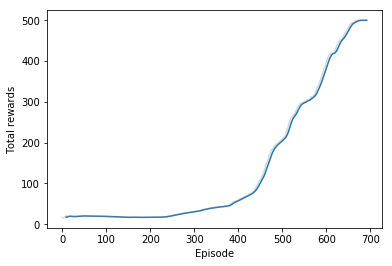

In [20]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

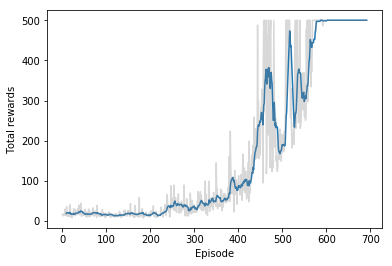

In [21]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-qn.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))
# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model-qn.ckpt


/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.